# AI-ветеринар: Искусственный интеллект на страже здоровья буренок

Данные содержат поле “text” с описаниями признаков болезней в свободной форме от пользователей и 11 полей с возможными заболеваниями (1 - есть заболевания, 0 - нет):

- эймериоз
- абсцесс
- диспепсия молодняка
- остертагиоз
- мастит
- инфекционный ринотрахеит
- отёк вымени
- тенденит
- сибирская язва
- лишай
- другое (иные заболевания)

Класс «другое» означает, что по описанию болезни также можно предположить наличие какой-то иной болезни (не из заданных 10)

В рамках задачи нужно предсказать
1. label – вероятность каждого из 11 возможных заболеваний **(порядок соответствует списку выше)**
2. span – индексы начала и конца размеченных признаков болезни

Первая подзадача является multilabel классификацией, то есть для каждого примера возможно наличие нескольких болезней. Метрикой в данном случае является значение 1 - LogLoss. Был также дан бейзлайн, который решал данную подзадачу.

Вторая подзадача является задачей классификацией токенов. Как метрика считается F1-score между истинными токенами (словами) и предсказанными. Никакого бейзлайна не дано.

Более подробно рассказано здесь https://russianhackers.notion.site/AI-7b798dfd94a9416ea5353a6aa16790d5

|Что надо сделать|Задача|Количество размеченных данных|Метрика|Наличие бейзлайна|
|-|-|:-:|-|:-:|
|Найти вероятность болезней по тексту|multilabel классификация болезней|294|1 - LogLoss|Да|
|Найти признаки болезней в тексте|классификация токенов|30|F1 между истинными и предсказанными токенами|Нет|

В бейзлайне для первой подзадачи лосс получился равен 0.3409663042406871.

# Подготовка окружения

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/My Drive/agrocode/ds/train.zip"
!unzip "/content/drive/My Drive/agrocode/ds/test.csv.zip"

In [ ]:
# fasttext модель, обученная на датасете RuDRec
# https://drive.google.com/file/d/1su3IYY1avcj95tez69JI8f5qsTng72-I/view
!git clone https://github.com/matthuisman/gdrivedl.git
file_id = '1su3IYY1avcj95tez69JI8f5qsTng72-I'
!python ./gdrivedl/gdrivedl.py $file_id

In [ ]:
!pip install catboost
!pip install datasets
!pip install transformers
!pip install optuna
!pip install fasttext
!pip install rusenttokenize

!pip install summa

# Импорт модулей

Здесь импортирую модули и фиксирую сиды для воспроизводимости.

In [5]:
import json
import os
import random
import re
from itertools import chain
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC

import torch
from torch import nn
import transformers
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer, 
    BertForSequenceClassification,
    BertTokenizer, 
    FSMTModel, 
    FSMTTokenizer, 
    FSMTForConditionalGeneration,
    Trainer, 
    TrainingArguments,
)
import datasets
from datasets import Dataset
import optuna
from optuna.samplers import TPESampler
from rusenttokenize import ru_sent_tokenize
import fasttext
import fasttext.util
from tqdm.notebook import tqdm

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from summa.summarizer import summarize
from summa import keywords

russian_stopwords = stopwords.words("russian")

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
transformers.set_seed(SEED)

PATH = 'sberbank-ai/ruBert-base'

# делать ли аугментацию данных
AUG = False

# параметр max_length в токенизаторе
MAX_LENGTH = 256

# суммаризовать ли тексты - то есть извлечь самые важные предложения, уменьшив таким образом текст, 
# чтобы токенизатор мог их полностью переводить в токены
USE_SUMMARIZE = False
MAX_WORDS = 200

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def load_model(path):
    if not os.path.exists(path):
        if path == 'sberbank-ai/ruBert-base':
            tokenizer = BertTokenizer.from_pretrained(path)
            model = BertForSequenceClassification.from_pretrained(path, num_labels=11)
            tokenizer.save_pretrained(path)
            model.save_pretrained(path)
        else:
            tokenizer = AutoTokenizer.from_pretrained(path)
            model = AutoModel.from_pretrained(path, num_labels=11)
            tokenizer.save_pretrained(path)
            model.save_pretrained(path)
    else:
        if 'sberbank' in path:
            tokenizer = BertTokenizer.from_pretrained(path)
        else:
            tokenizer = AutoTokenizer.from_pretrained(path)

    def model_init():
        return AutoModelForSequenceClassification.from_pretrained(
            path, num_labels=11, problem_type = "multi_label_classification")
    
    return tokenizer, model_init

Предобработка как в ноутбуке https://github.com/cimm-kzn/RuDReC/blob/master/examples/Raw_preprocessing.ipynb

Это нужно, чтобы использовать модель FastText из того же репозитория.

In [7]:
def list_replace(search, replacement, text):
    """
    Replaces all symbols of text which are present
    in the search string with the replacement string.
    """
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text

def clean_text(text):

    text = list_replace \
        ('\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019', '\u0022', text)

    text = list_replace \
        ('\u2012\u2013\u2014\u2015\u203E\u0305\u00AF', '\u2003\u002D\u002D\u2003', text)

    text = list_replace('\u2010\u2011', '\u002D', text)

    text = list_replace \
            (
            '\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000',
            '\u2002', text)

    text = re.sub('\u2003\u2003', '\u2003', text)
    text = re.sub('\t\t', '\t', text)

    text = list_replace \
            (
            '\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062',
            '.', text)

    text = list_replace('\u2217', '\u002A', text)

    text = list_replace('…', '...', text)
    text = list_replace('\u00C4', 'A', text)
    text = list_replace('\u00E4', 'a', text)
    text = list_replace('\u00CB', 'E', text)
    text = list_replace('\u00EB', 'e', text)
    text = list_replace('\u1E26', 'H', text)
    text = list_replace('\u1E27', 'h', text)
    text = list_replace('\u00CF', 'I', text)
    text = list_replace('\u00EF', 'i', text)
    text = list_replace('\u00D6', 'O', text)
    text = list_replace('\u00F6', 'o', text)
    text = list_replace('\u00DC', 'U', text)
    text = list_replace('\u00FC', 'u', text)
    text = list_replace('\u0178', 'Y', text)
    text = list_replace('\u00FF', 'y', text)
    text = list_replace('\u00DF', 's', text)
    text = list_replace('\u1E9E', 'S', text)
    # Removing punctuation
    text = list_replace(',.[]{}()=+-−*&^%$#@!~;:§/\|\?"\n', ' ', text)
    # Replacing all numbers with masks
    text = list_replace('0123456789', 'x', text)

    currencies = list \
            (
            '\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192'
        )

    alphabet = list \
            (
            '\t\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ')

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = ''.join(cleaned_text)

    # cleaned_text = re.sub(' +', ' ', cleaned_text)

    return cleaned_text.lower()

# Перефразирование обучающих примеров

Код из этой статьи https://habr.com/ru/post/564916/

Перефразирование текстов является хорошей аугментацией для текста, так как при перефразирование смысл сохраняется, но используются уже другие слова.

В моем случае не было заметного улучшения между тем, чтобы обучаться на исходных текстах и перефразированных или только исходных. Поэтому я решил не использовать данный метод.

In [8]:
class Paraphraser:
    def __init__(self):
        self.tokenizer = FSMTTokenizer.from_pretrained("facebook/wmt19-en-ru")
        self.model = FSMTForConditionalGeneration.from_pretrained("facebook/wmt19-en-ru")
        self.inverse_tokenizer = FSMTTokenizer.from_pretrained("facebook/wmt19-ru-en")
        self.inverse_model = FSMTForConditionalGeneration.from_pretrained("facebook/wmt19-ru-en")
        self.model.cuda()
        self.inverse_model.cuda()

    def paraphrase(self, text, gram=4, num_beams=5, **kwargs):
        """ Generate a paraphrase using back translation. 
        Parameter `gram` denotes size of token n-grams of the original sentence that cannot appear in the paraphrase.
        """
        input_ids = self.inverse_tokenizer.encode(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.inverse_model.generate(input_ids.to(self.inverse_model.device), num_beams=num_beams, **kwargs)
        other_lang = self.inverse_tokenizer.decode(outputs[0], skip_special_tokens=True)
        input_ids = input_ids[0, :-1].tolist()
        bad_word_ids = [input_ids[i:(i+gram)] for i in range(len(input_ids)-gram)]
        if len(bad_word_ids) == 0:
            bad_word_ids = None
        input_ids = self.tokenizer.encode(other_lang, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model.generate(input_ids.to(self.model.device), num_beams=num_beams, bad_words_ids=bad_word_ids, **kwargs)
        decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded

    def paraphrase_example(self, example):
        sents = ru_sent_tokenize(example)
        return ' '.join(self.paraphrase(sent, max_length=128) for sent in sents)

Функция, которая вычисляет метрику для первой подзадачи

В качестве "gt" (ground truth) функция принимает на вход датафрейм/массив из 10 столбцов (все классы, кроме "другое"). Предсказанные значения – "pr", также должны быть либо в виде датафрейма, либо в виде массива.

In [24]:
def log_loss_score(gt, pr):
    
    log_loss_ = 0
    
    gt = np.array(gt)
    
    for i in range(10):
        log_loss_ += metrics.log_loss(gt[:, i], pr[:, i])
        
    return log_loss_ / 10

# Загрузка данных

Тренировочные данные состоят из полей 'text_id', 'text' и 11 полей с таргетами. Не стоит забывать, что может быть больше одной болезни для каждого случая.

Тестовые же данные содержат поля 'text_id' и 'text'.

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
train = train.sample(frac=1., random_state=SEED)

В среднем 50.54081632653061 слов в примере


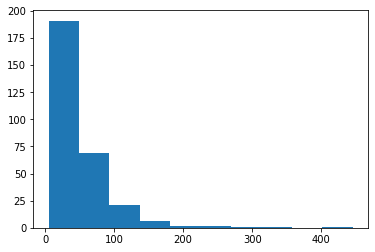

In [12]:
plt.hist([len(clean_text(text).split()) for text in train.text])
print(f'В среднем {np.mean([len(clean_text(text).split()) for text in train.text])} слов в примере')

Как видно сверху большинство примеров имеют меньше 200 слов и в среднем в примере содержится ~50.54 слов. Так как есть примеры, с большим количеством слов, при токенизации таких примеров часть слов из последних предложений отбрасывалась. У меня появилась идея суммаризовать их (т.е. найти самые важные предложения в тексте) и таким образом уменьшить количество слов в таких примерах. Среди методов суммаризации есть те, которые требуют предварительного обучения на размеченных корпусах, и те, которые работают без обучения. Я попробовал второй вариант, так как не имел размеченных корпусов и не нашел подходящих уже обученных моделей на русском. В итоге, я нашел библиотеку summa, в которой реализован метод TextRank для предложений. Никакого прироста по метрике не было замечено при обучении на суммаризованных предложений, так что я не использовал это.

In [13]:
if USE_SUMMARIZE:
    def shrink(text, max_words=MAX_WORDS):
        if len(text.split()) < max_words:
            return text
        return ' '.join(summarize(text, words=max_words, split=True))
    train['text'] = train['text'].apply(shrink)
    test['text'] = test['text'].apply(shrink)

if AUG:
    train_size = int(len(train)*0.8) * 2

    paraphraser = Paraphraser()
    aug_train = train[:int(len(train)*0.8)].copy()
    aug_train['text'] = aug_train['text'].apply(paraphraser.paraphrase_example)
    aug_train = aug_train.sample(frac=1., random_state=SEED + 1)
    train = pd.concat((aug_train, train))
else:
    train_size = int(len(train)*0.8)

In [14]:
test.head(2)

,text_id,text
0,294,Понос у месячных телят. Подскажите методы и сп...
1,295,"Понос у телят, чем лечить? \nЧем можно вылечит..."


# Нейронка

Первоначальная идея для первой подзадачи - это использовать предобученный на русский язык трансформер (нейронная сеть для задач NLP, использующая механизм внимания). Среди моделей, обученных на русских, не так уж много моделей, подходящих для классификации, мною были рассмотрены только модели на базе BERT и RoBERTa. Сильной разницы в метрики между ними не заметил, но размер модели RoBERTa был сильно больше (в открытом доступе только модель, весящая 1.33 Гб) и, вследствие этого, обучение занимало гораздо много времени. По итогу выбор был сделан в сторону модели на базе BERT.

In [ ]:
tokenizer, model_init = load_model(PATH)

In [ ]:
dataset = Dataset.from_pandas(train)
pred_dataset = Dataset.from_pandas(test)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=MAX_LENGTH, truncation=True)

def create_labels(example):
    example['labels'] = torch.tensor(list(map(example.get, train.columns[2:].tolist())), dtype=torch.float)
    return example

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.map(create_labels, remove_columns=train.columns[2:].tolist())
dataset = dataset.remove_columns('text_id')

pred_dataset = Dataset.from_pandas(test)
pred_dataset = pred_dataset.map(tokenize_function, batched=True)

datasets = dataset.train_test_split(train_size=train_size, seed=SEED, shuffle=False)

https://wandb.ai/amogkam/transformers/reports/Hyperparameter-Optimization-for-Hugging-Face-Transformers--VmlldzoyMTc2ODI - здесь посмотрел, какие гиперпараметры больше всего влияют на обучение

https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10 - здесь посмотрел, как оптимизировать гиперпараметры

Для того, чтобы получить самый низкий лосс на валидации, я воспользовался методом trainer.hyperparameter_search, который пробует разные вариации гиперпараметров и смотрит лосс у каждой вариации. Итогом этого является конкретные значения гиперпараметров.

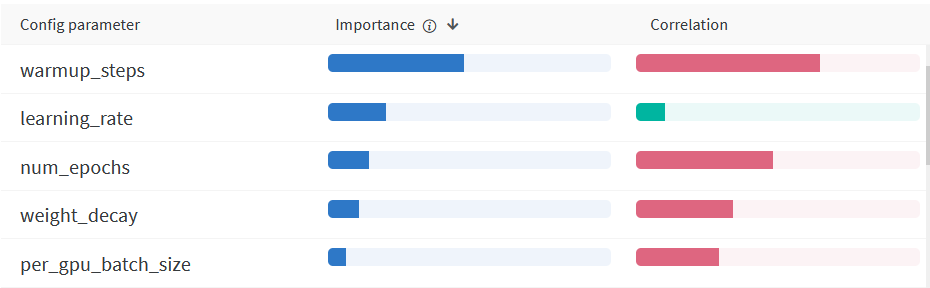

# Тренировка нейронки

Значения гиперпараметров были получены с помощью optuna

In [17]:
hyperparams = {
    'warmup_steps': 27, 
    'learning_rate': 9.565499215943819e-05, 
    'num_train_epochs': 20, 
    'weight_decay': 0.09094110816767033, 
    'per_device_train_batch_size': 6}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=25,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    save_total_limit=1,
    overwrite_output_dir=True,
    save_steps=500,
    **hyperparams
)

trainer = Trainer(
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['test'],
    model_init=model_init,
)

trainer.train()

In [ ]:
outputs = trainer.predict(datasets['test'])
predictions = torch.sigmoid(torch.from_numpy(outputs.predictions)).numpy()

In [25]:
print('Logloss:', log_loss_score(train.tail(len(train) - train_size)[train.columns[-11:-1]], predictions))

Logloss: 0.2164904848745456


# Поиск признаков болезней
Поиск признаков происходит с помощью fasttext модели, обученной на RuDRec.

Найденные признаки очищаются от стоп-слов и трансформируются в векторное пространство с помощью такой же модели, но векторное пространство которой урезано до 50-мерного пространство.

## Подготовка данных

In [26]:
with open('train_labels.json') as f:
    train_labels = json.loads(f.read())

train_labels_ = {}
for key in train_labels:
    spans = train_labels[key]['span']
    if len(spans) == 0:
        continue
    train_labels_[key] = {'text': train[train.text_id == int(key)].text.values[0], 'span': spans}

Код ниже отвечает за вычисление метрики.

In [27]:
def f1_span_score_per_text(ground_truth_labels, my_labels, text):
    
    span_my_tokens = list()
    span_gt_tokens = list()
    
    if len(my_labels):
        span_my_words = [text[s[0]:s[1]] for s in my_labels]
        span_my_tokens = [re.sub('[^А-Яа-яёЁ ]+', '', item) for sublist in span_my_words for item in sublist.split()]

    if len(ground_truth_labels):
        span_gt_words = [text[s[0]:s[1]] for s in ground_truth_labels]
        span_gt_tokens = [re.sub('[^А-Яа-яёЁ ]+', '', item) for sublist in span_gt_words for item in sublist.split()]

    if len(span_my_tokens) == 0 or len(span_gt_tokens) == 0:
        return int(span_my_tokens == span_gt_tokens)
    
    tp = np.sum(list((Counter(span_gt_tokens) & Counter(span_my_tokens)).values()))

    precision = tp/len(span_my_tokens)
    recall = tp/len(span_gt_tokens)

    if precision + recall > 0:
        return 2*precision*recall/(precision+recall)
    else:
        return 0
    
def total_f1_score(ground_truth_labels, my_labels, data):
    f1_scores = list()
    for k in ground_truth_labels.keys():
        text = data.loc[data['text_id'] == int(k), 'text'].values[0]
        f1_score_per_text = f1_span_score_per_text(ground_truth_labels[k]['span'], my_labels[k]['span'], text)
        f1_scores.append(f1_score_per_text)
        
    return np.mean(f1_scores)

Модель fasttext весит около 2 Гб, но так как библиотека FastText от Facebook хорошо оптимизирована, то все вычисления занимают очень мало времени.

In [ ]:
ft_model = fasttext.load_model('rudrec_fasttext_model.bin')

## Поиск кандидатов среди неразмеченных слов
Размечены только 30 примеров, среди остальных примеров может быть ещё много слов, которые достаточно близки к размеченным, но не размечены. Эти слова можно использовать для улучшения алгоритма поиска признаков болезней.

Для того, чтобы понять что слово является признаком болезни, я измеряю косинусную меру между данным словом (кандидат) и словами, которые точно являются признаками болезни (помечены признаками болезни в размеченных примерах). Если мера превышает порог между данным словом и каким-нибудь словом-признаком, то я считаю это слово тоже признаком болезни.

Также из размеченных примеров можно точно понять, какие слова не являются признаками болезни. Я также использую эту информацию, проверяя, что кандидат не принадлежит к таким словам.

In [29]:
def is_similar(word_vector, vectors_compare_with, threshold=0.5):
    vecs = cosine_similarity(word_vector[np.newaxis, :], vectors_compare_with)
    return np.any(vecs > threshold)

In [30]:
def take_not_spans(text, spans):
    take_sym = []
    span_idx = 0
    for idx in range(len(text)):
        if idx >= spans[span_idx][1] and span_idx < len(spans) - 1:
            span_idx += 1
        if idx >= spans[span_idx][0] and idx < spans[span_idx][1]:
            take_sym.append(False)
        else: take_sym.append(True)
    return ''.join(x for idx, x in enumerate(text) if take_sym[idx])

In [31]:
min_candidate_threshold = 0.4

train_words = set()
candidates = set()

filter_sw = lambda x: filter(lambda y: y not in russian_stopwords and y is not None, x.split())

keys = list(train_labels_.keys())
for key in keys:
    exmpl = train_labels_[key]
    sent = exmpl['text']
    train_words.update(chain(*[filter_sw(clean_text(sent[a:b])) for a, b in exmpl['span']]))
train_word_vectors = np.array([ft_model.get_word_vector(word) for word in train_words])

for key in tqdm(train_labels):
    if len(train_labels[key]['span']) != 0:
        continue
    text = train[train.text_id == int(key)].text.values[0]
    for word in clean_text(text).split():
        if word is None:
            continue
        add = is_similar(ft_model.get_word_vector(word), train_word_vectors, threshold=min_candidate_threshold)
        if word not in russian_stopwords and word not in train_words and add:
            candidates.add(word)

for _, row in test.iterrows():
    text = row['text']

    for word in clean_text(text).split():
        if word is None:
            continue
        add = is_similar(ft_model.get_word_vector(word), train_word_vectors, threshold=min_candidate_threshold)
        if word not in russian_stopwords and word not in train_words and add:
            candidates.add(word)

train_words = list(train_words)

  0%|          | 0/294 [00:00<?, ?it/s]

In [32]:
test_candidate_threshold = 0.9

def find_candidates_vectors(candidate_vectors, candidate_threshold, word_vectors=train_word_vectors):
    vecs = cosine_similarity(candidate_vectors, word_vectors)
    filtering = np.any(vecs > candidate_threshold, axis=1)
    return candidate_vectors[filtering]

def find_candidates(candidates, candidate_threshold, word_vectors=train_word_vectors):
    func = lambda x: is_similar(ft_model.get_word_vector(x), word_vectors, threshold=candidate_threshold)
    return list(filter(func, candidates))

print(find_candidates(candidates, test_candidate_threshold))

['подкашливает', 'немножко', 'пьет', 'течет', 'запоносили', 'жидковатый']


## Поиск оптимальных параметров
Поиск происходит с помощью библиотеки optuna. Я ввел 4 параметра и с помощью библиотеки перебрал разные их вариации, для того, чтобы найти оптимальный вариант.

*threshold* - порог, по которому слово из неразмеченных текстов считается за слово, содержащее признак болезни. Вычисляется косинусное расстояние.

*filter_stopwords* - флаг, фильтровать ли стоп-слова (слова, не несущие смысла - частицы, предлоги, союзы и т.д.)

*max_span_dist_merge* - fasttext хорошо находит обычные слова, но не стоп-слова, тем не менее признаком болезни может быть и фраза, включающая стоп-слова. Для того, чтобы улучшить метрику, я ввел этот параметр. Если между двумя спанами меньше символов, чем значение параметра, то эти два спана сливаются в один.

*candidate_threshold* - насколько близко (по косинусному расстоянию) должно быть слово-кандидат к размеченным словам, чтобы его добавить к размеченным словам.

In [33]:
def find_spans(text, word_vectors, threshold, max_span_dist_merge, filter_sw, notcandidates):
    spans = []

    for m in re.finditer(r'\S+', text):
        index, item = m.start(), m.group()
        cleaned_item = clean_text(item)
        if cleaned_item is None:
            continue
        pos = 0
        for word in filter_sw(cleaned_item):
            add = is_similar(ft_model.get_word_vector(word), word_vectors, threshold)
            pos = cleaned_item.find(word, pos)
            if add and word not in notcandidates:
                spans.append([index + pos, index + pos + len(word)])
            pos += len(word) - 1

    if max_span_dist_merge > 0 and len(spans) > 0:
        new_spans = []
        merge = []
        for sp1, sp2 in zip(spans[:-1], spans[1:]):
            merge.append(sp2[0] - sp1[1] - 1 <= max_span_dist_merge)
        left = spans[0][0]
        for idx in range(len(merge)):
            if merge[idx]:
                continue
            new_spans.append([left, spans[idx][1]])
            left = spans[idx + 1][0]
        new_spans.append([left, spans[-1][1]])
        spans = new_spans
    
    return spans

В качестве проверки модели, я использую метод LeaveOneOut, таким образом предсказываю признаки болезней для всех размеченных примеров, а потом проверяю с истинными признаками. По итогу optuna в конце возвращает конкретные значения параметров, при которых метрика F1 была больше всего.

In [34]:
keys = list(train_labels_.keys())
loo = LeaveOneOut()

def objective(trial):
    threshold = trial.suggest_float('threshold', 0., 1.,)
    filter_stopwords = trial.suggest_categorical('filter_stopwords', [False, True])
    max_span_dist_merge = trial.suggest_int('max_span_dist_merge', 0, 20)
    candidate_threshold = trial.suggest_float('candidate_threshold', 0.5, 1.0)
    
    if filter_stopwords:
        filter_sw = lambda x: filter(lambda y: y not in russian_stopwords, x.split())
    else:
        filter_sw = lambda x: x.split()

    preds = dict()
    for train_index, test_index in tqdm(loo.split(train_labels_), total=len(train_labels_)):
        test_idx = test_index[0]
        
        words = set()
        notcandidates = set()
        for idx in train_index:
            exmpl = train_labels_[keys[idx]]
            sent = exmpl['text']
            words.update(chain(*[filter_sw(clean_text(sent[a:b])) for a, b in exmpl['span']]))
            notcandidates.update(filter_sw(clean_text(take_not_spans(sent, exmpl['span']))))
        notcandidates = notcandidates - words
        word_vectors = np.array([ft_model.get_word_vector(word) for word in words])

        candidates_ = candidates - notcandidates
        candidate_vectors = np.array([ft_model.get_word_vector(word) for word in candidates_])
        new_vectors = find_candidates_vectors(candidate_vectors, candidate_threshold, word_vectors)
        word_vectors = np.vstack((word_vectors, new_vectors))

        test_exmpl = train_labels_[keys[test_idx]]
        
        spans = find_spans(test_exmpl['text'], word_vectors, threshold, max_span_dist_merge, filter_sw, notcandidates)
        preds[keys[test_idx]] = {'span': spans}

    return total_f1_score(train_labels_, preds, train)

sampler = TPESampler(seed=SEED)

In [ ]:
study = optuna.create_study(directions=["maximize"], sampler=sampler)
study.optimize(objective, n_trials=100, timeout=3600)

In [36]:
best_params = study.best_trials[0].params
best_params

{'candidate_threshold': 0.6742901793717561,
 'filter_stopwords': True,
 'max_span_dist_merge': 1,
 'threshold': 0.467297166456727}

## Поиск признаков болезней для неразмеченных примеров

Значения параметров, полученные на предыдущем шаге, будут использованы здесь. На данном шаге я из текста примера оставляю только слова, которые мой алгоритм считает признаками болезни.

Из отфильтрованного таким образом текста составляется новый столбец для исходных выборок.

In [39]:
threshold = best_params['threshold']
filter_stopwords = best_params['filter_stopwords']
max_span_dist_merge = 0
candidate_threshold = best_params['candidate_threshold']

if filter_stopwords:
    filter_sw = lambda x: filter(lambda y: y not in russian_stopwords and y is not None, x.split())
else:
    filter_sw = lambda x: x.split()

words = set()
notcandidates = set()
for key in keys:
    exmpl = train_labels_[key]
    sent = exmpl['text']
    words.update(chain(*[filter_sw(clean_text(sent[a:b])) for a, b in exmpl['span']]))
    notcandidates.update(filter_sw(clean_text(take_not_spans(sent, exmpl['span']))))
notcandidates = notcandidates - words
word_vectors = np.array([ft_model.get_word_vector(word) for word in words])

candidates_ = candidates - notcandidates
candidate_vectors = np.array([ft_model.get_word_vector(word) for word in candidates_])
new_vectors = find_candidates_vectors(candidate_vectors, candidate_threshold, word_vectors)
word_vectors = np.vstack((word_vectors, new_vectors))

train_dis_features = []

for _, row in tqdm(train.iterrows(), total=len(train)):
    text = row['text']
    spans = find_spans(text, word_vectors, threshold, max_span_dist_merge, filter_sw, notcandidates)
    train_dis_features.append(' '.join(text[l:r] for l, r in spans))

if 'dis_features' not in train.columns:
    train.insert(loc=2,
                 column='dis_features',
                 value=train_dis_features)
else:
    train.dis_features = train_dis_features


test_dis_features = []

for _, row in tqdm(test.iterrows(), total=len(test)):
    text = row['text']
    spans = find_spans(text, word_vectors, threshold, max_span_dist_merge, filter_sw, notcandidates)
    test_dis_features.append(' '.join(text[l:r] for l, r in spans))

if 'dis_features' not in test.columns:
    test.insert(loc=2,
                column='dis_features',
                value=test_dis_features)
else:
    test.dis_features = test_dis_features

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

## Удаление стоп-слов и добавление в датасет

Из отфильтрованного текста удаляю стоп-слова (предлоги, частицы и т.д.).

In [40]:
def remove_stopwords(text, stopwords=russian_stopwords):
    return ' '.join(filter(lambda x: x not in stopwords, text.split()))

train.dis_features = train.dis_features.map(clean_text).map(remove_stopwords)
test.dis_features = test.dis_features.map(clean_text).map(remove_stopwords)

Пример получившегося текста ниже

In [41]:
train.dis_features.tolist()[:20]

['запоносил',
 'паратифа',
 'вымени ранка зарубцевалась опухла вымени',
 'искривился молочный канал молоко фонтаном тяжело',
 'отелилась отек убавили давали отек спал рацион появляться отек отека каждый вымя молоко отек отек',
 'поднялась температура сопит хрипит сопит менее нос пускает пузыри надувает щёки антибиотиками лечились ривициклин норсульфазол пьёт молоко сбавляет',
 'сказали меньше кормлю понос кровью',
 'вспотел поносит умерла',
 'тёлке плохо ест пьёт лижет лёд отворачивается',
 'кашель сопли сгустками крови сопли сгустками крови кашель температура аппетит характерный покупали поноса антибиотика девочку колоть',
 'годовалый кашлять годовалый кашлять',
 'высыпания шее высыпания шее',
 'передние ноги бегал плохо стал вставать вечеру передние ноги поджал задними передвигается ест пьет вставать передние ноги разгибаются коленках заболеванием',
 'ноги',
 'поносит тилозин',
 'ветеринар понимает челюстью шишка куриное нижней челюстью шишка куриное зимой прорвало подсохло ветеринар

## Генерирация вектора с помощью fasttext модели

Загружаю ту же модель fasttext, но уже урезаю вектороное пространство до 50. Я проверил опытным путем, что на 50-мерных векторах catboost классификатор работает лучше всего.

In [ ]:
ft_model_vec = fasttext.load_model('rudrec_fasttext_model.bin')
fasttext.util.reduce_model(ft_model_vec, 50)

Для каждого примера вычисляется усредненный по всем словам в примере вектор.

In [43]:
train_embeddings = np.vstack(train.dis_features.map(ft_model_vec.get_sentence_vector).values)
test_embeddings = np.vstack(test.dis_features.map(ft_model_vec.get_sentence_vector).values)

# OneVsRest-Catboost модель

Данная модель была в бейзлайне и было проверено, что она дает хорошие результаты на векторах от fasttext модели.

In [44]:
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(train_embeddings), train[train.columns[-11:]], train_size=train_size, shuffle=False)

In [ ]:
model = OneVsRestClassifier(estimator=CatBoostClassifier(iterations = 400, random_seed=SEED,
                                                         verbose = 50, allow_writing_files=False))
model.fit(X_train, y_train)

# Подсчет метрики

Метрика для OneVsRest-Catboost модели

In [46]:
log_loss_score(y_val, model.predict_proba(X_val))

0.23462034052264963

Усредним предсказания нейронки и модели выше

In [ ]:
outputs = trainer.predict(datasets['test'])
predictions = torch.sigmoid(torch.from_numpy(outputs.predictions)).numpy()

In [49]:
ensemble_preds = (model.predict_proba(X_val) + predictions) / 2.
log_loss_score(y_val, ensemble_preds)

0.192663341894461

# Результаты

||Logloss|
|-|-|
|Бейзлайн|0.3409663042406871|
|Нейронная сеть*|0.2343362271785736|
|FastText + CatBoost|0.23462034052264963|
|Ансамбль**|0.19626982821112623|

*Нейронная сеть - трансформер ruBert-base от сбера

**Ансамбль - усредненные предсказания нейронной сети и FastText + CatBoost

# Выводы

По итогу, нет заметной разницы в лоссе между нейронной сетью и моделью fasttext+catboost. Но при этом если нейронной сети для быстрой работы нужна видеокарта, то вторая модель работает уже просто на процессоре, при этом колаб для работы выделяет очень мощную видеокарту и крайне посредственный процессор.

Также fasttext модель в связке fasttext+catboost может быть сжата (например, как описано в этой статье https://habr.com/ru/post/582980/) и таким образом это решение можно сделать ещё менее требовательным к ресурсам.

Ансамбль хоть и показывает улучшение, но если выбирать решение для прода, то оно не подходит, так как требует нейронку, а это требует гораздо больших ресурсов и следовательно больше денег. Поэтому, в итоге наилучшим решением является fasttext+catboost.